In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm

In [52]:
from scipy.stats import boxcox
def box_delta(row):
    row = pd.Series(row,index = cut_time_index)
    select_Data = row[row > 0]
    if len(np.unique(select_Data)) <= 2:
        return pd.Series(np.nan,index = cut_time_index).values
    y, lambda0 = boxcox(select_Data, lmbda=None, alpha=None)
    transformed_data = pd.Series(y,index=select_Data.index)
    delta_Data = transformed_data - transformed_data.shift(1)
    return pd.Series(delta_Data,index  = cut_time_index).values
cut_time_index = ff.read_min('000001.SZ').iloc[-240:]['close'][1:-1].index
close_ = ff.read('close').loc[:,'20200102':'20240701']
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
full_time_index = ff.read('close').loc[:,'20200102':'20240701'].columns

In [53]:
def justice_factor(stock):
    try:
        data = ff.read_min(stock).loc['2020-01-02 09:31:00':'2024-07-01 15:00:00']
    except:
        return pd.Series(np.nan,index = full_time_index).values
    if len(data) == 0:
        return pd.Series(np.nan,index = full_time_index).values
    rolldata = ff.rolling_window(data['volume'],240)
    day_index= pd.unique(pd.to_datetime(data.index).strftime("%Y%m%d"))
    indice = 240 * np.arange(int((rolldata.shape[0] -1)/240)+1)
    dailydata = rolldata[indice,1:-1]
    cut_time_index = data.iloc[-240:]['close'][1:-1].index
    delta_data = pd.DataFrame(np.apply_along_axis(box_delta, axis=1, arr=dailydata))
    rollclosedata = ff.rolling_window(data['close'],240)
    # indice = 240 * np.arange(int((rollclosedata.shape[0] -1)/240)+1)
    close_data = pd.DataFrame(rollclosedata[indice,1:-1])
    vio_data = ((close_data.pct_change(1,axis = 1)).rolling(5,axis = 1).std()).shift(-5, axis = 1)
    shine_5_data = vio_data[(delta_data.T > delta_data.mean(axis = 1) + delta_data.std(axis = 1)).T] 
    dim_5_data = delta_data[(delta_data.T < delta_data.mean(axis = 1) - delta_data.std(axis = 1)).T]
    justice_data = ret.loc[stock] * pd.Series((np.abs(shine_5_data.mean(axis = 1) - dim_5_data.mean(axis = 1))).values,index = day_index)
    justice_factor = justice_data.rolling(20).mean()
    return pd.Series(justice_factor,index = full_time_index).values

In [5]:
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(justice_factor, ff.cl), total=len(ff.cl)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5299/5299 [09:01<00:00,  9.78it/s]


In [6]:
factor_result = np.vstack(res_lst)

In [7]:
factor_result = pd.DataFrame(factor_result,index = ff.cl,columns=ff.read('close').loc[:,'20200102':'20240701'].columns)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


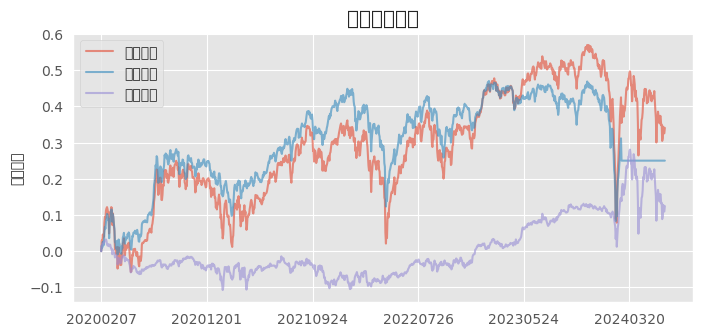

,指数收益,超额收益,策略收益
年化收益率,0.059,0.029,0.080
年化波动率,0.204,0.146,0.281
夏普率,0.287,0.200,0.284
最大回撤,-0.387,-0.232,-0.491
收益回撤比,0.151,0.126,0.162
胜率,0.490,0.510,0.547
盈亏比,1.096,0.999,0.870


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.029  0.080
 年化波动率  0.204  0.146  0.281
 夏普率    0.287  0.200  0.284
 最大回撤  -0.387 -0.232 -0.491
 收益回撤比  0.151  0.126  0.162
 胜率     0.490  0.510  0.547
 盈亏比    1.096  0.999  0.870,
                 策略     index          策略收益      指数收益      超额收益
 20200207  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200210  1.029781  1.015485  2.934583e-02  0.015366  0.014195
 20200211  1.027456  1.009975  2.708584e-02  0.009925  0.017358
 20200212  1.047142  1.026166  4.606488e-02  0.025829  0.020482
 20200213  1.039102  1.016279  3.835684e-02  0.016148  0.022436
 ...            ...       ...           ...       ...       ...
 20240625  1.366789  1.284230  3.124640e-01  0.250159  0.096377
 20240626  1.410604  1.284230  3.440182e-01  0.250159  0.127932
 20240627  1.386763  1.284230  3.269725e-01  0.250159  0.110886
 20240628  1.384825  1.284230  3.255737e-01  0.250159  0.109487
 20240701  1.405845  1.284230  3.406383e-01  0.250159  0.124552
 
 [106

In [10]:
ff.run((factor_result)*ff.filter0.loc[:,'20200102':'20240701'], positions = 100, period = 1, fees = 0) 

In [14]:
factor_result.loc['000001.SZ'].dropna()

20200207   -0.055477
20200210   -0.056757
20200211   -0.055862
20200212   -0.056990
20200213   -0.057256
              ...   
20240625   -0.022222
20240626   -0.022012
20240627   -0.002985
20240628   -0.001167
20240701    0.000233
Name: 000001.SZ, Length: 1068, dtype: float64

In [ ]:
from scipy.stats import boxcox
def box_delta1(row):
    row = pd.Series(row,index = full_minute_index)
    select_Data = row[1:-1][row[1:-1] > 0]
    if len(np.unique(select_Data)) <= 2:
        return pd.Series(np.nan,index = full_minute_index).values
    y, lambda0 = boxcox(select_Data, lmbda=None, alpha=None)
    transformed_data = pd.Series(pd.Series(y,index=select_Data.index),index = full_minute_index)
    return (transformed_data - transformed_data.shift(1)).values
close_ = ff.read('close').loc[:,'20200102':]
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
full_time_index = ff.read('close').loc[:,'20200102':].columns
full_minute_index = ff.read_min('000001.SZ')['volume'][-240:].index
def justice_factor1(stock):
    try:
        data = ff.read_min(stock).loc['2020-01-02 09:31:00':]
    except:
        return pd.Series(np.nan,index = full_time_index).values
    if len(data) == 0:
        return pd.Series(np.nan,index = full_time_index).values
    rolldata = ff.rolling_window(data['volume'],240)
    day_index= pd.unique(pd.to_datetime(data.index).strftime("%Y%m%d"))
    indice = 240 * np.arange(int((rolldata.shape[0] -1)/240)+1)
    dailydata = rolldata[indice]
    delta_data = pd.DataFrame(np.apply_along_axis(box_delta1, axis=1, arr=dailydata))
    rollclosedata = ff.rolling_window(data['close'],240)
    close_data = pd.DataFrame(rollclosedata[indice])
    vio_data = ((close_data.pct_change(1,axis = 1)).rolling(5,axis = 1).std()).shift(-5, axis = 1)
    shine_5_data = vio_data[(delta_data.T > delta_data.mean(axis = 1) + delta_data.std(axis = 1)).T] 
    dim_5_data = delta_data[(delta_data.T < delta_data.mean(axis = 1) - delta_data.std(axis = 1)).T]
    justice_data = ret.loc[stock] * pd.Series((np.abs(shine_5_data.mean(axis = 1) - dim_5_data.mean(axis = 1))).values,index = day_index)
    justice_factor = justice_data.rolling(20).mean()
    return pd.Series(justice_factor,index = full_time_index).values

In [ ]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(justice_factor, ff.cl), total=len(ff.cl)))

In [73]:
from scipy.stats import boxcox
def box_delta(row):
    row = pd.Series(row,index = full_minute_index)
    select_Data = row[1:-1][row[1:-1] > 0]
    if len(np.unique(select_Data)) <= 2:
        return pd.Series(np.nan,index = full_minute_index).values
    y, lambda0 = boxcox(select_Data, lmbda=None, alpha=None)
    transformed_data = pd.Series(pd.Series(y,index=select_Data.index),index = full_minute_index)
    return (transformed_data - transformed_data.shift(1)).values
close_ = ff.read('close').loc[:,'20200102':'20240701']
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
full_time_index = ff.read('close').loc[:,'20200102':'20240701'].columns
full_minute_index = ff.read_min('000001.SZ')['volume'][-240:].index
def justice_factor(stock):
    try:
        data = ff.read_min(stock).loc['2020-01-02 09:31:00':'2024-07-01 15:00:00']
    except:
        return pd.Series(np.nan,index = full_time_index).values
    if len(data) == 0:
        return pd.Series(np.nan,index = full_time_index).values
    dailydata = data['volume'].values.reshape(-1,240)
    close_data = pd.DataFrame(data['close'].values.reshape(-1,240))
    day_index= pd.unique(pd.to_datetime(data.index).strftime("%Y%m%d"))
    delta_data = pd.DataFrame(np.apply_along_axis(box_delta, axis=1, arr=dailydata))
    vio_data = ((close_data.pct_change(1,axis = 1)).rolling(5,axis = 1).std()).shift(-5, axis = 1)
    shine_5_data = vio_data[(delta_data.T > delta_data.mean(axis = 1) + delta_data.std(axis = 1)).T] 
    dim_5_data = delta_data[(delta_data.T < delta_data.mean(axis = 1) - delta_data.std(axis = 1)).T]
    justice_data = ret.loc[stock] * pd.Series((np.abs(shine_5_data.mean(axis = 1) - dim_5_data.mean(axis = 1))).values,index = day_index)
    justice_factor = justice_data.rolling(20).mean()
    return pd.Series(justice_factor,index = full_time_index).values

In [74]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(justice_factor, ff.cl), total=len(ff.cl)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5299/5299 [04:40<00:00, 18.92it/s]


In [75]:
factor_result = np.vstack(res_lst)

In [76]:
factor_result = pd.DataFrame(factor_result,index = ff.cl,columns=ff.read('close').loc[:,'20200102':'20240701'].columns)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


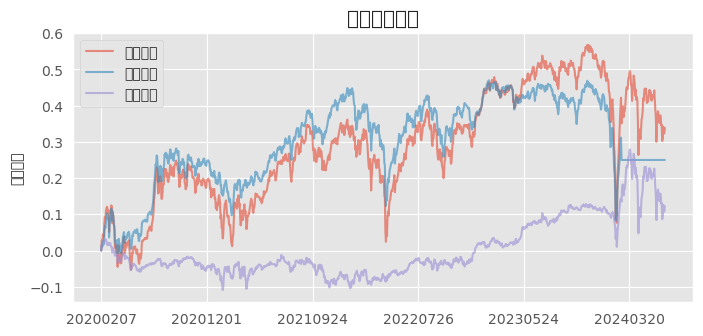

,指数收益,超额收益,策略收益
年化收益率,0.059,0.029,0.079
年化波动率,0.204,0.146,0.281
夏普率,0.287,0.197,0.282
最大回撤,-0.387,-0.232,-0.491
收益回撤比,0.151,0.124,0.161
胜率,0.490,0.512,0.549
盈亏比,1.096,0.991,0.863


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.029  0.079
 年化波动率  0.204  0.146  0.281
 夏普率    0.287  0.197  0.282
 最大回撤  -0.387 -0.232 -0.491
 收益回撤比  0.151  0.124  0.161
 胜率     0.490  0.512  0.549
 盈亏比    1.096  0.991  0.863,
                 策略     index          策略收益      指数收益      超额收益
 20200207  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200210  1.029213  1.015485  2.879424e-02  0.015366  0.013635
 20200211  1.026483  1.009975  2.613879e-02  0.009925  0.016405
 20200212  1.045966  1.026166  4.494072e-02  0.025829  0.019349
 20200213  1.037739  1.016279  3.704438e-02  0.016148  0.021117
 ...            ...       ...           ...       ...       ...
 20240625  1.364053  1.284230  3.104603e-01  0.250159  0.094419
 20240626  1.408070  1.284230  3.422200e-01  0.250159  0.126179
 20240627  1.384272  1.284230  3.251743e-01  0.250159  0.109133
 20240628  1.381948  1.284230  3.234939e-01  0.250159  0.107453
 20240701  1.402882  1.284230  3.385285e-01  0.250159  0.122487
 
 [106

In [77]:
ff.run((factor_result)*ff.filter0.loc[:,'20200102':'20240701'], positions = 100, period = 1, fees = 0) 